In this notebook, we will implement a Convoulutional Neural Network (CNN) using pytorch for CIFAR-10 Classification.

Expectations: Please provide solutions to the questions in the cells at the end of the notebook.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

We will be using [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) datasets which is sub-dataset of CIFAR-100 Dataset. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. <br>

Following are the classes in the dataset along with some random samples.

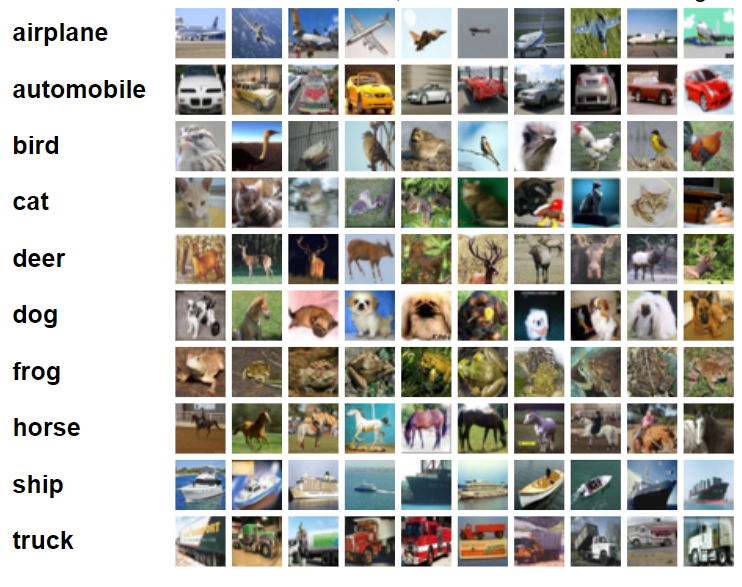

We will use pytorch datasets to fetch the CIFAR-10 dataset as it provides a handy way to get and use the dataset. More information about pytorch datasets [here](https://pytorch.org/vision/stable/datasets.html).

In [54]:

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)


100%|██████████| 170498071/170498071 [00:01<00:00, 104638345.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 10/10 [25:48<00:00, 154.86s/it]


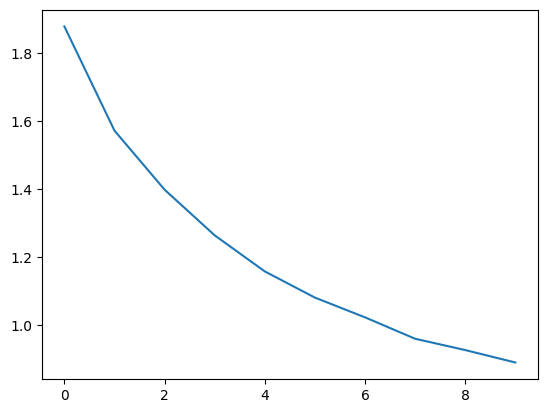

In [56]:
device = torch.device("cuda:0")
net2 = models.resnet18(num_classes = 10)
net2 = net2.to(device)
lr = 1e-1
momentum = 0.5
num_epochs = 10
opt = optim.SGD(net2.parameters(), lr = lr, momentum = 0.5)
ls = []
for i in tqdm(range(num_epochs)):
  total_loss = 0
  for batch in train_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = net2(X)
    loss = F.cross_entropy(yhat, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))

plt.plot(ls)

In [57]:
correct = 0
total = 0
with torch.no_grad():
  for batch in test_loader:
    X,y = batch[0].to(device), batch[1].to(device)
    yhat = net2(X)
    labels = torch.argmax(yhat, dim = 1)
    correct +=  torch.sum(labels==y)
    total+=y.shape[0]


print(f"accuracy is {correct/total}")



accuracy is 0.780299961566925


## Transfer Learning

Transfer learning means taking the relevant parts of a pre-trained machine learning model and applying it to a new but similar problem. Transfer learning brings a range of benefits to the development process of machine learning models. The main benefits of transfer learning include the saving of resources and improved efficiency when training new models. It can also help with training models when only unlabelled datasets are available, as the bulk of the model will be pre-trained.

![Transfer Learning](https://topb0ts.wpenginepowered.com/wp-content/uploads/2019/12/cover_transfer_learning_1600px_web.jpg) [Source](https://www.topbots.com/transfer-learning-in-nlp/)

In [58]:
net = models.resnet18(pretrained = True)
net

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [59]:

#freeze the backbone and train the last layer only

for params in net.parameters():
  params.requires_grad = False

In [ ]:
# net.fc = nn.Linear(in_features=512, out_features=10, bias=True)

In [60]:
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)
# nn.fc = nn.Sequential([
#     nn.Linear(in_features=512, out_features=100, bias=True),
#     nn.Linear(in_features=512, out_features=10, bias=True),
# ])
for params in net.parameters():
  print(params.requires_grad)

# train teh network normally for a few iternations:---> only update is for the last layer



False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_losses = []

num_epochs = 10

for epoch in range(num_epochs):

    net.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/10, Loss: 1.3939468054747095
Epoch 2/10, Loss: 0.8340907604718695
Epoch 3/10, Loss: 0.7075368762016296
Epoch 4/10, Loss: 0.6344962740431026
Epoch 5/10, Loss: 0.5867826491594315
Epoch 6/10, Loss: 0.5582046063274754
Epoch 7/10, Loss: 0.5327528780516313
Epoch 8/10, Loss: 0.517860226941352
Epoch 9/10, Loss: 0.4988023795339526
Epoch 10/10, Loss: 0.4794570666794874


Post training accuracy

In [ ]:
net.eval()

correct = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        correct += (predicted == labels).sum().item()

print(f"Post training on the test set: {100 * correct / len(test_loader.dataset)}%")

Post training on the test set: 92.68%


In [6]:
#Q1: define a 2 layer simple NN for cifar10 classificaiton

In [7]:
#Q2: Define a CNN with 2 conv layer and 2 linear layers for cifar10 classificaiton

In [8]:
#Q3: Train both networks for 10 epochs and compare their performance

In [9]:
#Q4: Compare the accuarcay of both networks on the test set

In [10]:
#Q5: Fine-tune ResNet18 model trained on ImageNet for CIFAR10 dataset.

In [11]:
#Q6:Compare the accuarcay of simple CNN and ResNet18 model on the test set